## Feature selection

Correlation Feature Selection evaluates subsets of features on the basis of the following hypothesis: "Good feature subsets contain features highly correlated with the target, yet uncorrelated to each other".

I will demonstrate how to select features based on correlation using 2 procedures:

The first one is a brute force function that finds correlated features without any further insight.

The second procedure finds groups of correlated features, which we can then explore to decide which one we keep and which ones we discard.

Often, more than 2 features are correlated with each other. We can find groups of 3, 4 or more features that are correlated. By identifying these groups, with procedure 2, we can then select from each group, which feature we want to keep, and which ones we want to remove.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
import os

from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, DropCorrelatedFeatures

from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
# to obtain the mutual information values
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

# to determine the p-values with anova
from sklearn.feature_selection import f_classif

# to select features
from sklearn.feature_selection import SelectKBest

# to select the features
from sklearn.feature_selection import SelectKBest, SelectPercentile
import xgboost as xgb
from xgboost import XGBClassifier
from ngboost import NGBClassifier
from ngboost.distns import k_categorical

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, balanced_accuracy_score

In [2]:
# Import dataset
load_dotenv()
dataset_path=os.getenv("DATASET_PATH")
dataset = pd.read_csv(dataset_path)
dataset.head()

,RID,Gender,Ageatscreening,Diagnosis,MMSE0m,HipsASMbaseline,HipsContrastbaseline,HipsCorelationbaseline,HipsVariancebaseline,HipsSumAveragebaseline,...,ERCsContrastbaseline,ERCsCorelationbaseline,ERCsVariancebaseline,ERCsSumAveragebaseline,ERCsSumVariancebaseline,ERCsEntropybaseline,ERCsClusterShadebaseline,ERCs_thicknessbaseline,ERCsVolumebaseline,HipposcampusVolumebaseline
0,3,0,81.3479,3,20.0,NaN,158.27,0.63,218.30,28.37,...,253.10,0.40,208.65,23.39,581.50,NaN,-2568.19,2.31,1176.0,3047.0
1,4,0,67.6904,1,27.0,0.06,147.64,0.55,173.64,44.72,...,220.88,0.48,215.70,33.74,641.90,3.33,4113.01,2.76,1942.0,3449.0
2,5,0,73.8027,0,29.0,0.10,199.66,0.55,222.27,41.18,...,220.37,0.54,232.18,29.18,708.36,2.87,-1388.41,3.18,2044.0,3441.0
3,8,1,84.5945,0,28.0,0.08,184.21,0.53,201.55,43.04,...,198.42,0.54,220.48,26.68,683.50,2.77,-2506.55,2.68,1959.0,2875.0
4,10,1,73.9726,3,24.0,0.11,233.02,0.48,229.88,39.46,...,196.55,0.53,210.63,26.60,645.95,2.72,-1164.02,2.64,1397.0,2700.0


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset.drop("Diagnosis", axis=1),  
    dataset["Diagnosis"],  
    test_size=0.3,  
    random_state=42,  
)

In [4]:
imputer_missForest = IterativeImputer(
    estimator=ExtraTreesRegressor(n_estimators=10, random_state=42),
    max_iter=10,
    random_state=42,
)

imputer_missForest.fit(X_train)
X_train_missForest = imputer_missForest.transform(X_train)
X_test_missForest = imputer_missForest.transform(X_test)

c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [5]:
X_train_missForest_t = pd.DataFrame(X_train_missForest, columns=X_train.columns)
X_test_missForest_t = pd.DataFrame(X_test_missForest, columns=X_test.columns)

In [6]:
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=1, variables=None, missing_values='raise')),
    ('quasi-constant', DropConstantFeatures(tol=0.998, variables=None, missing_values='raise')),
    ('duplicated', DropDuplicateFeatures()),
])

pipe.fit(X_train_missForest_t)

Pipeline(steps=[('constant', DropConstantFeatures()),
                ('quasi-constant', DropConstantFeatures(tol=0.998)),
                ('duplicated', DropDuplicateFeatures())])

In [7]:
constant_step = pipe.named_steps['constant']
quasi_constant_step = pipe.named_steps['quasi-constant']
duplicated_step = pipe.named_steps['duplicated']

print("Constant features removed:", constant_step.features_to_drop_)
print("Quasi-constant features removed:", quasi_constant_step.features_to_drop_)
print("Duplicate features removed:", duplicated_step.features_to_drop_)

Constant features removed: []
Quasi-constant features removed: []
Duplicate features removed: set()


In [8]:
mi = mutual_info_classif(
    X = X_train_missForest_t, 
    y = y_train,
    discrete_features = False, 
    n_neighbors=3,
    random_state=3,
)

mi

array([0.09515599, 0.        , 0.10239353, 0.46764701, 0.02460466,
       0.        , 0.        , 0.00507885, 0.        , 0.        ,
       0.10466653, 0.04149519, 0.01820184, 0.10741063, 0.11479634,
       0.00255568, 0.02208289, 0.05663916, 0.08053496, 0.        ,
       0.12054121, 0.20363503, 0.17988955])

Text(0, 0.5, 'Mutual Information')

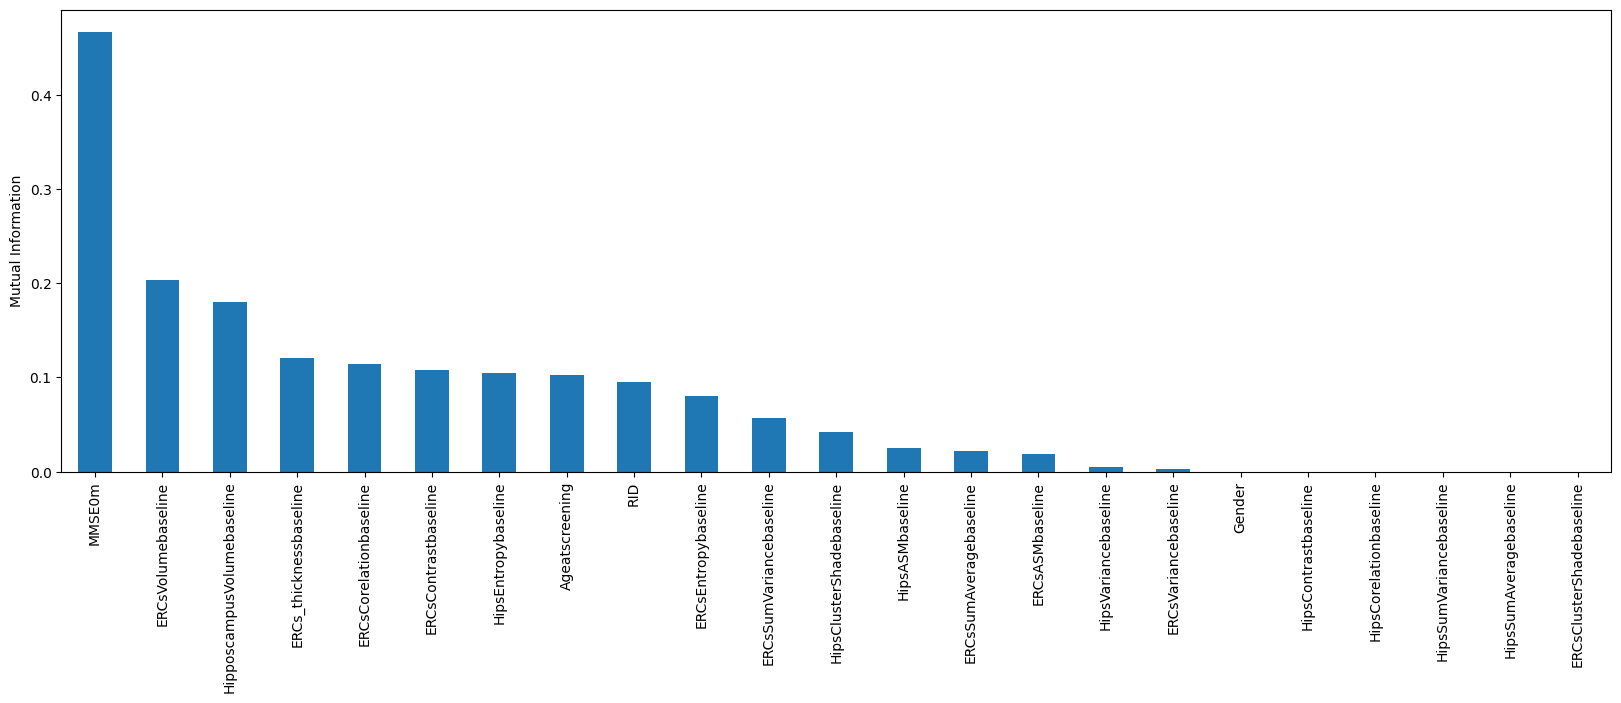

In [9]:
# 1) let's capture the above array in a pandas series
# 2)add the variable names in the index
# 3) sort the features based on their mutual information value
# 4) and make a var plot

mi = pd.Series(mi)
mi.index = X_train.columns
mi.sort_values(ascending=False).plot.bar(figsize=(20, 6))
plt.ylabel('Mutual Information')

In [10]:
# here we will select the top 10 features
# based on their mutual information value

# select features
mi_selection = SelectKBest(mutual_info_classif, k=10).fit(X_train_missForest_t, y_train)

# display features
selected_features_mi = X_train.columns[mi_selection.get_support()]
selected_features_mi

Index(['RID', 'Ageatscreening', 'MMSE0m', 'HipsEntropybaseline',
       'ERCsContrastbaseline', 'ERCsCorelationbaseline', 'ERCsEntropybaseline',
       'ERCs_thicknessbaseline', 'ERCsVolumebaseline',
       'HipposcampusVolumebaseline'],
      dtype='object')

In [11]:
# remove unwanted features from the dataset
X_train_anova = mi_selection.transform(X_train_missForest_t)
X_test_anova = mi_selection.transform(X_test_missForest_t)

# Convert transformed arrays back into DataFrames with the correct feature names
X_train_t = pd.DataFrame(X_train_anova, columns=selected_features_mi)
X_test_t = pd.DataFrame(X_test_anova, columns=selected_features_mi)

X_train_t.shape, X_test_t.shape

((425, 10), (183, 10))

## Classification Test

In [12]:
def run_model(classifier_name, X_train, y_train):

        # Initialize the model based on classifier_name
        if classifier_name == "Random Forest":
                model = RandomForestClassifier(n_estimators=100, 
                                        max_depth=5, 
                                        random_state=42, 
                                        class_weight="balanced")
                
        elif classifier_name == "XGBoost":
        # XGBClassifier sometimes issues warnings about label encoding. 
        # We disable the use_label_encoder and set an evaluation metric.
                model = XGBClassifier(n_estimators=100, 
                                max_depth=5, 
                                random_state=42,
                                eval_metric="logloss")
        
        elif classifier_name == "NGBoost":
                model = NGBClassifier(Dist=k_categorical(len(np.unique(y_train))),
                                      n_estimators=100,
                                      verbose=False) 

        else:
                raise ValueError("Unknown classifier")
                
        kf = StratifiedKFold(n_splits=10,
                             shuffle=True,
                             random_state=42,
        )
        
        cross_val_results = cross_validate(model,
                                           X_train,
                                           y_train,
                                           cv=kf,
                                           scoring="balanced_accuracy",
                                           return_train_score=True,
        )
               
        # Calculate the metrics for training and testing
        mean_train = [round(np.mean(cross_val_results["train_score"]), 3)]
        std_train = [round(np.std(cross_val_results["train_score"]), 3)]
        mean_test = [round(np.mean(cross_val_results["test_score"]), 3)]
        std_test = [round(np.std(cross_val_results["test_score"]), 3)]
        time = round(np.mean(cross_val_results["fit_time"]), 3)
                
        cv_metrics_df = pd.DataFrame({
                "Feature Selection": "Mutual Information",
                "Classifier": classifier_name,
                "Fit Time": time,
                "Total Features": len(X_train.columns),
                "Metric": "balanced_accuracy",
                "Mean Train": mean_train,
                "Std Train": std_train,
                "Mean Test": mean_test,
                "Std Test": std_test,
        })
        
        fit_model = model.fit(X_train, y_train)
        
        return fit_model, cv_metrics_df


In [13]:
trained_rf_n, metrics_rf_n = run_model("Random Forest", X_train_missForest_t, y_train)
trained_rf_t, metrics_rf_t = run_model("Random Forest", X_train_t, y_train)

trained_xgb_n, metrics_xgb_n = run_model("XGBoost", X_train_missForest_t, y_train)
trained_xgb_t, metrics_xgb_t = run_model("XGBoost", X_train_t, y_train)

trained_ngb_n, metrics_ngb_n = run_model("NGBoost", X_train_missForest_t, y_train)
trained_ngb_t, metrics_ngb_t = run_model("NGBoost", X_train_t, y_train)

In [14]:
validation_df = pd.concat([metrics_rf_n, metrics_rf_t, metrics_xgb_n, metrics_xgb_t, metrics_ngb_n, metrics_ngb_t])
validation_df_report = validation_df.set_index(["Feature Selection", "Classifier", "Metric", "Fit Time", "Total Features"])
validation_df_report

Mean Train  \
Feature Selection  Classifier    Metric            Fit Time Total Features               
Mutual Information Random Forest balanced_accuracy 0.998    23                   0.891   
                                                   0.483    10                   0.872   
                   XGBoost       balanced_accuracy 1.595    23                   1.000   
                                                   0.493    10                   1.000   
                   NGBoost       balanced_accuracy 2.117    23                   0.698   
                                                   1.858    10                   0.666   

                                                                            Std Train  \
Feature Selection  Classifier    Metric            Fit Time Total Features              
Mutual Information Random Forest balanced_accuracy 0.998    23                  0.010   
                                                   0.483    10                  0.009   
                   XGBoost       balanced_accuracy 1.595    23                  0.000   
                                                   0.493    10                  0.000   
                   NGBoost       balanced_accuracy 2.117    23                  0.019   
                                                   1.858    10                  0.016   

                                                                            Mean Test  \
Feature Selection  Classifier    Metric            Fit Time Total Features              
Mutual Information Random Forest balanced_accuracy 0.998    23                  0.575   
                                                   0.483    10                  0.566   
                   XGBoost       balanced_accuracy 1.595    23                  0.556   
                                                   0.493    10                  0.569   
                   NGBoost       balanced_accuracy 2.117    23                  0.546   
                                                   1.858    10                  0.544   

                                                                            Std Test  
Feature Selection  Classifier    Metric            Fit Time Total Features            
Mutual Information Random Forest balanced_accuracy 0.998    23                 0.062  
                                                   0.483    10                 0.081  
                   XGBoost       balanced_accuracy 1.595    23                 0.050  
                                                   0.493    10                 0.039  
                   NGBoost       balanced_accuracy 2.117    23                 0.054  
                                                   1.858    10                 0.052

In [15]:
import time

def eval_model(classifier_name, model, X_train, X_test, y_train, y_test):
        
        start_time = time.time()
        # Get predicted probabilities for ROC AUC
        pred_train_proba = model.predict_proba(X_train)
        pred_test_proba = model.predict_proba(X_test)
        
        # Get predicted accuracy values
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)
        
        # Calculate metrics
        metrics_train = {
                "accuracy": round(accuracy_score(y_train, pred_train), 3),
                "balanced_accuracy": round(balanced_accuracy_score(y_train, pred_train), 3),
                "precision": round(precision_score(y_train, pred_train, average="weighted"), 3),
                "recall": round(recall_score(y_train, pred_train, average="weighted"), 3),
                "f1_weighted": round(f1_score(y_train, pred_train, average="weighted"), 3),
                "roc_auc_ovr_weighted": round(roc_auc_score(y_train, pred_train_proba, average="weighted", multi_class="ovr"),3,),
        }
        
        metrics_test = {
                "accuracy": round(accuracy_score(y_test, pred_test), 3),
                "balanced_accuracy": round(balanced_accuracy_score(y_test, pred_test), 3),
                "precision": round(precision_score(y_test, pred_test, average="weighted"), 3),
                "recall": round(recall_score(y_test, pred_test, average="weighted"), 3),
                "f1_weighted": round(f1_score(y_test, pred_test, average="weighted"), 3),
                "roc_auc_ovr_weighted": round(roc_auc_score(y_test, pred_test_proba, average="weighted", multi_class="ovr"),3,),
        }
                
        elapsed_time = time.time() - start_time
    
        # Create the DataFrame without additional rounding
        pred_metrics_df = pd.DataFrame({
                "Feature Selection": "Mutual Information",
                "Classifier": classifier_name,
                "Classification Time": round(elapsed_time, 3),
                "Total Features": len(X_train.columns),
                "Metric": metrics_train.keys(),
                "Train data": metrics_train.values(),
                "Test data": metrics_test.values(),
    })
        
        return pred_metrics_df

In [16]:
results = "filtered"
prediction_df_report = None

if results == "all":
    pred_rf_n = eval_model("Random Forest", trained_rf_n, X_train_missForest_t, X_test_missForest_t, y_train, y_test)
    pred_rf_t = eval_model("Random Forest", trained_rf_t, X_train_t, X_test_t, y_train, y_test)

    pred_xgb_n = eval_model("XGBoost", trained_xgb_n, X_train_missForest_t, X_test_missForest_t, y_train, y_test)
    pred_xgb_t = eval_model("XGBoost", trained_xgb_t, X_train_t, X_test_t, y_train, y_test)

    pred_ngb_n = eval_model("NGBoost", trained_ngb_n, X_train_missForest_t, X_test_missForest_t, y_train, y_test)
    pred_ngb_t = eval_model("NGBoost", trained_ngb_t, X_train_t, X_test_t, y_train, y_test)
    
    prediction_df = pd.concat([pred_rf_n, pred_rf_t, pred_xgb_n, pred_xgb_t, pred_ngb_n, pred_ngb_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])
        
elif results == "filtered":
    pred_rf_t = eval_model("Random Forest", trained_rf_t, X_train_t, X_test_t, y_train, y_test)
    pred_xgb_t = eval_model("XGBoost", trained_xgb_t, X_train_t, X_test_t, y_train, y_test)
    pred_ngb_t = eval_model("NGBoost", trained_ngb_t, X_train_t, X_test_t, y_train, y_test)
    
    prediction_df = pd.concat([pred_rf_t, pred_xgb_t, pred_ngb_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])

prediction_df_report

Train data  \
Feature Selection  Classifier    Classification Time Total Features Metric                             
Mutual Information Random Forest 0.346               10             accuracy                   0.859   
                                                                    balanced_accuracy          0.866   
                                                                    precision                  0.864   
                                                                    recall                     0.859   
                                                                    f1_weighted                0.856   
                                                                    roc_auc_ovr_weighted       0.973   
                   XGBoost       0.297               10             accuracy                   1.000   
                                                                    balanced_accuracy          1.000   
                                                                    precision                  1.000   
                                                                    recall                     1.000   
                                                                    f1_weighted                1.000   
                                                                    roc_auc_ovr_weighted       1.000   
                   NGBoost       2.024               10             accuracy                   0.741   
                                                                    balanced_accuracy          0.654   
                                                                    precision                  0.734   
                                                                    recall                     0.741   
                                                                    f1_weighted                0.711   
                                                                    roc_auc_ovr_weighted       0.940   

                                                                                          Test data  
Feature Selection  Classifier    Classification Time Total Features Metric                           
Mutual Information Random Forest 0.346               10             accuracy                  0.574  
                                                                    balanced_accuracy         0.574  
                                                                    precision                 0.567  
                                                                    recall                    0.574  
                                                                    f1_weighted               0.566  
                                                                    roc_auc_ovr_weighted      0.842  
                   XGBoost       0.297               10             accuracy                  0.601  
                                                                    balanced_accuracy         0.575  
                                                                    precision                 0.585  
                                                                    recall                    0.601  
                                                                    f1_weighted               0.589  
                                                                    roc_auc_ovr_weighted      0.825  
                   NGBoost       2.024               10             accuracy                  0.579  
                                                                    balanced_accuracy         0.554  
                                                                    precision                 0.554  
                                                                    recall                    0.579  
                                                                    f1_weighted               0.542  
                                                                    roc